In [0]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import spacy
import nltk
from spacy import displacy
#Using NLP in spanish
nlp = spacy.load("es")

import os
from os import listdir
from os.path import isfile, join

from stop_words import get_stop_words
stop_words = get_stop_words('es')

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words). </span>

Cell 2:

# ***What?*** 
We are planning to analyze the speeches that peruvian presidents give once a year, for the last 60 years.  This corpora has been extracted fron PDF files that were downloaded from the peruvian congress. We are planning to do the following:
- Correlate the message's use of words by inspecting which are the most popular ones by presidential periods.
- Understand the varying context under which certain key words, like "peruano" (or peruvian) have evolved depending on the president who gave the speech. 
- Understand the main context given by key words in the speeches, where the word networks and document networks tells us who may be located at the center or the periphery of the speech.
- Understand the main topics that were addressed in the presidential messages.  
- Correlate reduced dimensions of the speeches with main economic indicators to see if there is a significant relation between them.

Cell 3:

## ***Why?***
This is a novel field in peruvian social studies. Academic research and also the average peruvian citizenship could benefit from it just by understanding better how each president's discourse change from one period to the other. The presidential speech is a long-awaited event in Peru, and people are often very expectant about what the president will say: Presidents usually tell a lot about what the policies for next year will look like, and use positive messages. Understanding these texts from the view of computational content analysis would add value by offering novel methods for investigating these. 

Cell 4:

## ***How?***
Many of the previous lectures have provided meaningful tools for approaching our research:
The corpora is already constructed and we have been analyzing it the past weeks. We will count words and phrases and report the most popular words and n-grams, check word dependencies, extract networks of words and documents, cluster the meaning of the documents to see wether there is any pattern, and also, we will use n-dimentional word vectors to interrogate our corpora in meaningful ways 


Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words). </span>

Cell 6:

We will use the whole set of available speeches, in that sense, we will use the maximum available information possible. Nevertheless, we will have to make inferences about the ways, trends, thoughts and meaning of each president, based on just one speech given in a year. In this case we want to analyze the anual presidential speeches, but an interesting turn would be to annotate each president by its political party, augment this corpora with the congress debates, and also classify them by political party, to see if there is a wider trend regarding policymaking, by political party, or even political thought.

In [0]:
def loadcorpus2(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in listdir(corpus_name + "/"):
        file2 = corpus_name + "/" + file
        print(file)
        texts_raw[file] = []
        with open(file2, encoding='utf-8') as f:
            for line in f:
                texts_raw[file].append(line)
    return texts_raw

In [0]:
speeches_dir = '/content/txt'
speeches_raw = loadcorpus2(speeches_dir)

mensaje-1991-af.txt
mensaje-2010-ag.txt
mensaje-1990-af.txt
mensaje-1984-fbt.txt
mensaje-2014-oh.txt
mensaje-2012-oh.txt
mensaje-2013-oh.txt
mensaje-2016-ppk.txt
mensaje-2007-ag.txt
mensaje-2017-ppk.txt
mensaje-2000-af.txt
mensaje-1980-fbt.txt
mensaje-1988-ag.txt
mensaje-1985-ag.txt
mensaje-2003-at.txt
mensaje-1992-af.txt
mensaje-2001-at.txt
mensaje-1987-ag.txt
mensaje-1997-af.txt
mensaje-1983-fbt.txt
mensaje-2002-at.txt
mensaje-1998-af.txt
mensaje-2009-ag.txt
mensaje-2004-at.txt
mensaje-1994-af.txt
mensaje-1982-fbt.txt
mensaje-1993-af.txt
mensaje-1995-af.txt
mensaje-1999-af.txt
mensaje-2011-oh.txt
mensaje-2018-4.txt
mensaje-1981-fbt.txt
mensaje-2015-oh.txt
mensaje-1989-ag.txt
mensaje-2019-01-vizcarra.txt
mensaje-2008-ag.txt
mensaje-2006-ag.txt
mensaje-1986-ag.txt
mensaje-1996-af.txt
mensaje-2005-at.txt


In [0]:
import re
speech = pandas.DataFrame()
filenames = []
raw = []
for filename, raw_speech in speeches_raw.items():
    filenames.append(filename)
    raw.append(raw_speech)
speech['filename'] = filenames
speech['raw text'] = raw

pattern = re.compile('[0-9]{4}')
speech['year'] = speech['filename'].apply(lambda x: pattern.search(x).group(0))
speech = speech.sort_values(by='year').reset_index(drop=True)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 


In the following lines we implement the analysis for 40 speeches, which go from 1980 to 2019. 

In [0]:
def clean_raw_text2(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            if type(text) == bytes:
                text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_text = clean_text.replace("\n", "").replace("\xa0", "").replace("\x0c", "")
            if not (clean_text == '' or clean_text == ' '):
                clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return ' '.join(clean_texts)

In [0]:
speech['cleaned text'] = speech['raw text'].apply(lambda x: clean_raw_text2(x))


In [0]:
speech.loc[(speech['year'].astype('int32') <= 1984), 'administration'] = 'Belaunde'

speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'administration'] = 'Garcia (1)'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 1994), 'administration'] = 'Fujimori(1)'

speech.loc[(speech['year'].astype('int32') >= 1995) & \
           (speech['year'].astype('int32') <= 2000), 'administration'] = 'Fujimori(2)'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'administration'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'administration'] = 'Garcia (2)'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'administration'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016), 'administration'] = 'Kuzcynski/Vizcarra'

speech.loc[(speech['year'].astype('int32') <= 1984), 'president'] = 'Belaunde'
speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 2000), 'president'] = 'Fujimori'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'president'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'president'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016) & \
           (speech['year'].astype('int32') <= 2017), 'president'] = 'Kuzcynski'

speech.loc[(speech['year'].astype('int32') >= 2018), 'president'] = 'Vizcarra'

speech['year-president'] = speech['year'] + '-' + speech['president']


In [0]:
speechTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(min_df=5, stop_words=stop_words, norm='l2')

In [0]:
targetDF = speech
textColumn = 'cleaned text'

In [0]:
speechTFVects = speechTFVectorizer.fit_transform(targetDF[textColumn])

In [0]:
terms = speechTFVectorizer.get_feature_names()

In [0]:
cat = [3,4,5,6,7]
for num in cat:
    numCategories = num
    speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
    speechKM.fit(speechTFVects)
    targetDF['kmeans' + str(numCategories)] = speechKM.labels_

In [0]:
speechPCA = sklearn.decomposition.PCA(n_components = 2).fit(speechTFVects.toarray())
reducedPCA_speechData = speechPCA.transform(speechTFVects.toarray())

Implementing K-means with 3, 4, 5, 6 and 7 clusters give a univocaly common answer: Each cluster is being conformed by the same presidential term! For example, speeches given by the same president form part of the same cluster. 

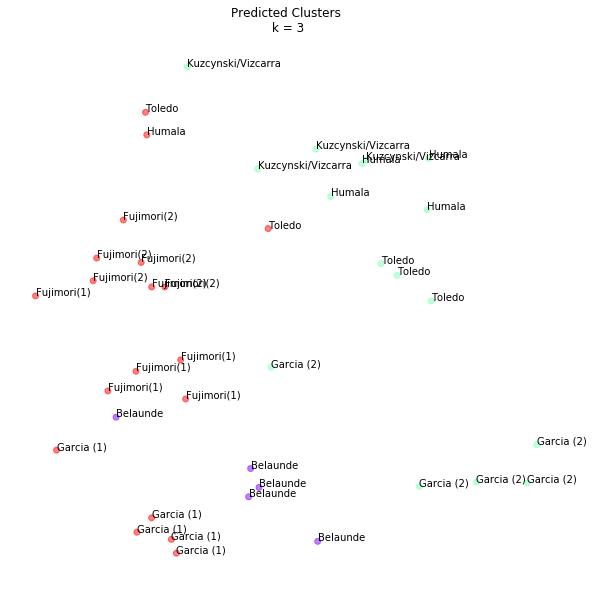

In [0]:
numCategories = 3
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
#for i, word in enumerate(words):
#    ax.annotate(word, (x[i],y[i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

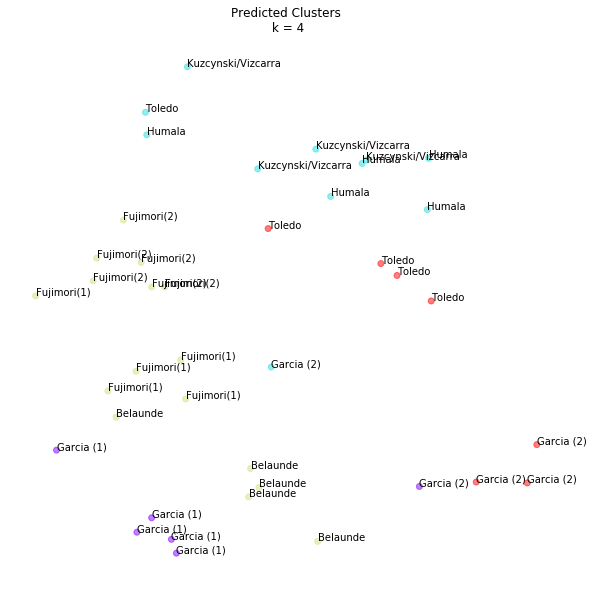

In [0]:
numCategories = 4
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

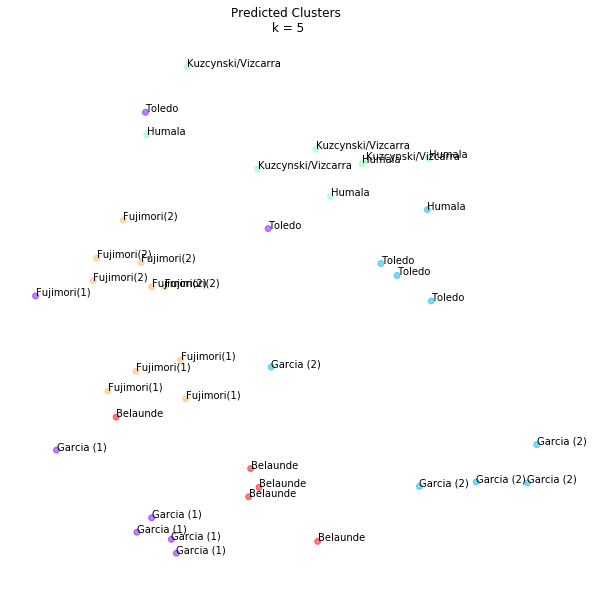

In [0]:
numCategories = 5
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

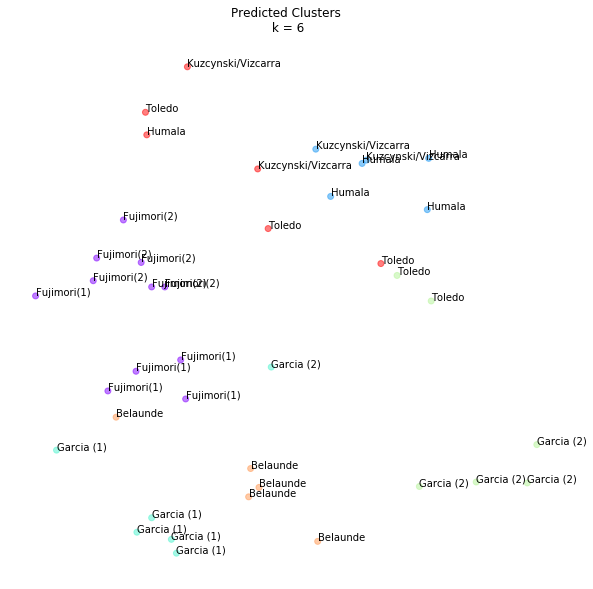

In [0]:
numCategories = 6
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

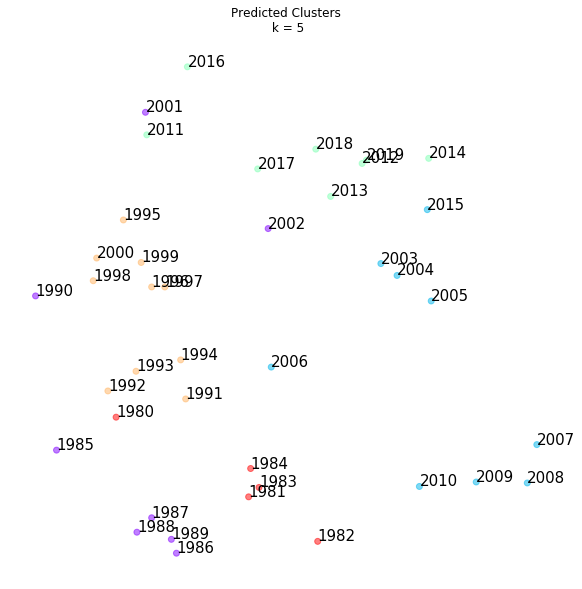

In [0]:
numCategories = 5
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

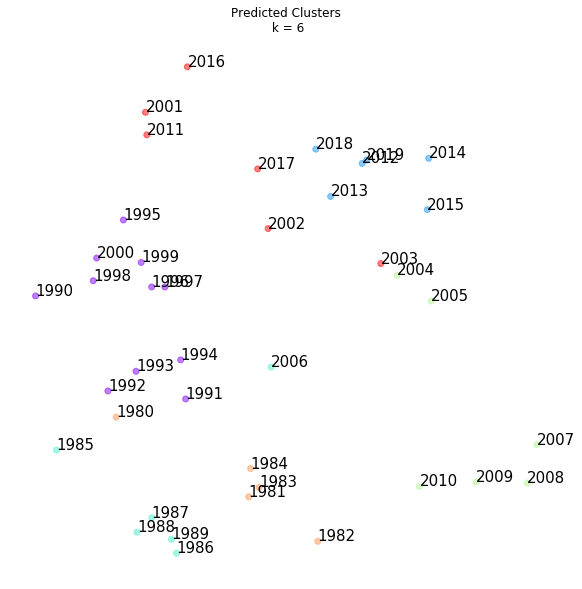

In [0]:
numCategories = 6
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

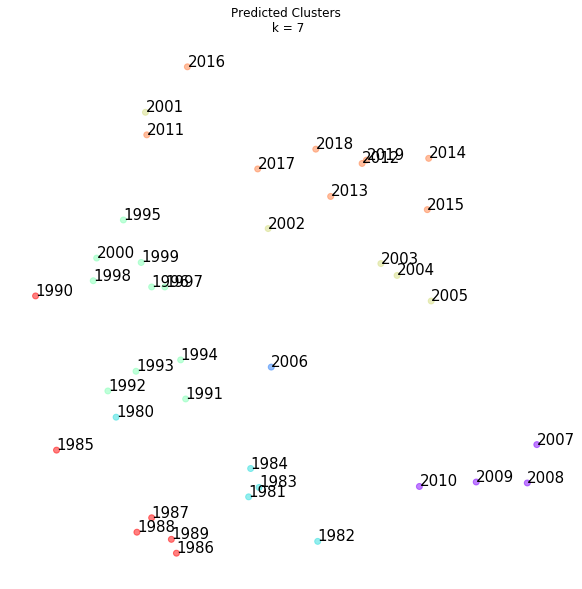

In [0]:
numCategories = 7
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

Checking the top terms per cluster, we see that words are still very similar between clusters, so differences might emerge in the less common words. 

In [0]:
terms = speechTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = speechKM.cluster_centers_.argsort()[:, ::-1]
for i in range(7):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mil
 millones
 perú
 año
 kilómetros
 soles
 obras
 años
 además
 gobierno
 país
 inversión
 ahora
 pueblo
 agua
 2006
 nacional
 mayor
 trabajo
 2011


Cluster 1:
 país
 millones
 empleo
 mil
 decreto
 peruanos
 perú
 deber
 gobierno
 pueblo
 años
 cada
 ley
 ello
 entrego
 social
 austeridad
 miseria
 recursos
 debe


Cluster 2:
 nacional
 gobierno
 país
 perú
 año
 desarrollo
 000
 mil
 millones
 1982
 debe
 1983
 obras
 1981
 construcción
 1980
 plan
 sistema
 social
 obra


Cluster 3:
 perú
 país
 gobierno
 nacional
 millones
 años
 desarrollo
 dólares
 año
 ser
 sólo
 pueblo
 hoy
 peruanos
 sector
 sino
 empresas
 si
 economía
 programa


Cluster 4:
 mil
 gobierno
 perú
 nacional
 millones
 año
 hoy
 soles
 país
 peruanos
 congreso
 ley
 presidente
 trabajo
 amigas
 programa
 pobreza
 dólares
 política
 juntos


Cluster 5:
 país
 perú
 año
 mil
 gobierno
 millones
 nacional
 salud
 peruanos
 soles
 000
 años
 2016
 corrupción
 desarrollo
 hoy
 p

In [0]:
def plotSilhouette2(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))
    return silhouette_avg

Checking the silhouette method for finding the ideal cluster size, we find that the ideal number of clusters is 9, which interestingly, are the number of presidents we are researching! Is each cluster one president?

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


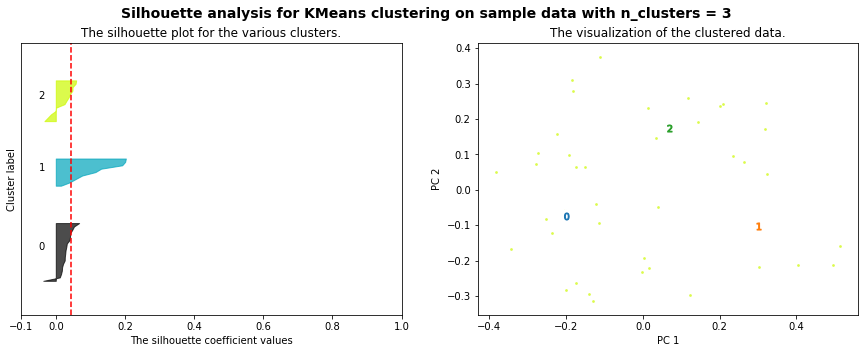

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


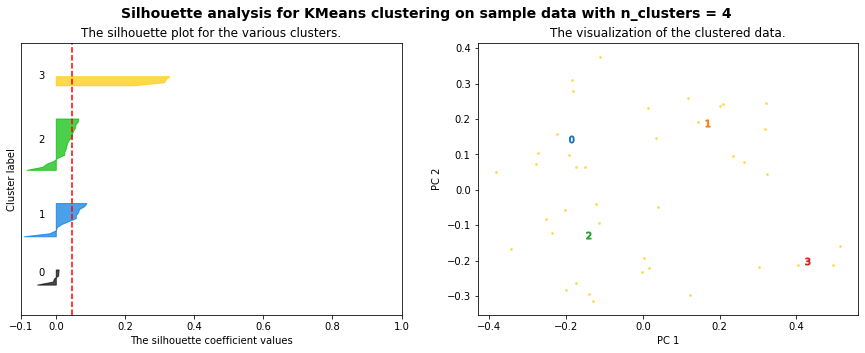

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 4, The average silhouette_score is : 0.048


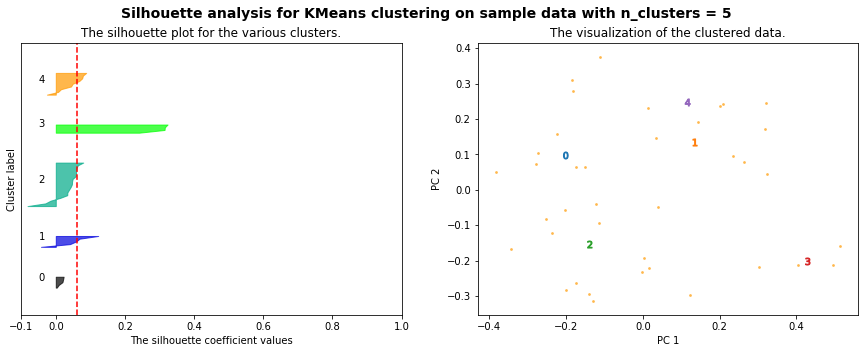

For n_clusters = 5, The average silhouette_score is : 0.062


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


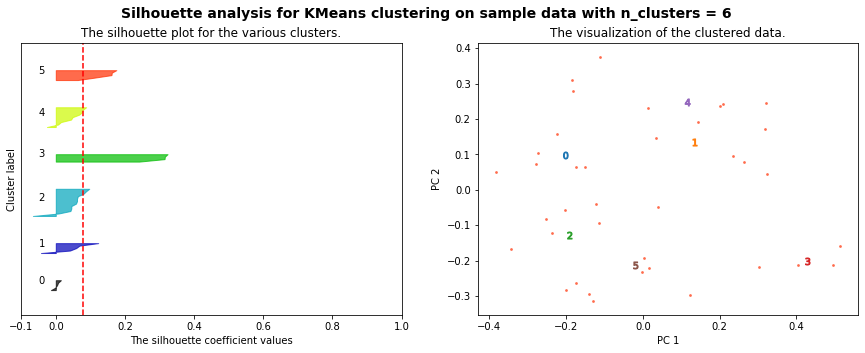

For n_clusters = 6, The average silhouette_score is : 0.078


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


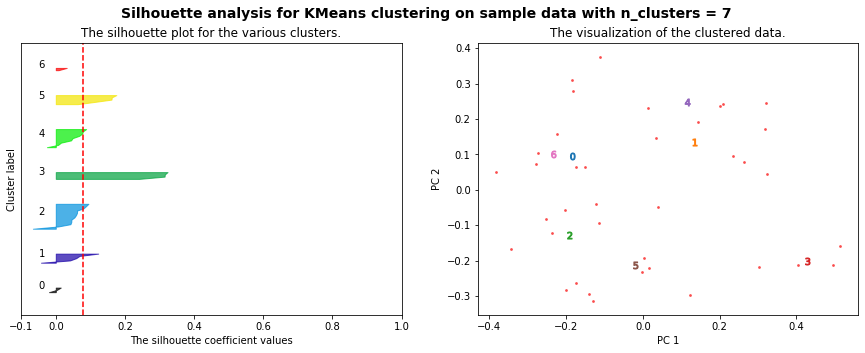

For n_clusters = 7, The average silhouette_score is : 0.078


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


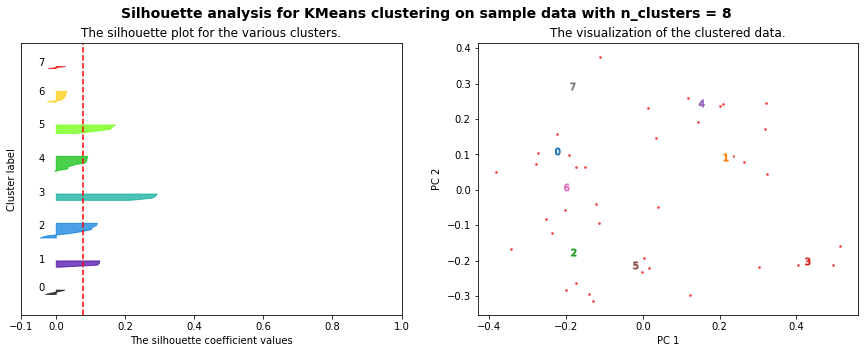

For n_clusters = 8, The average silhouette_score is : 0.079


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


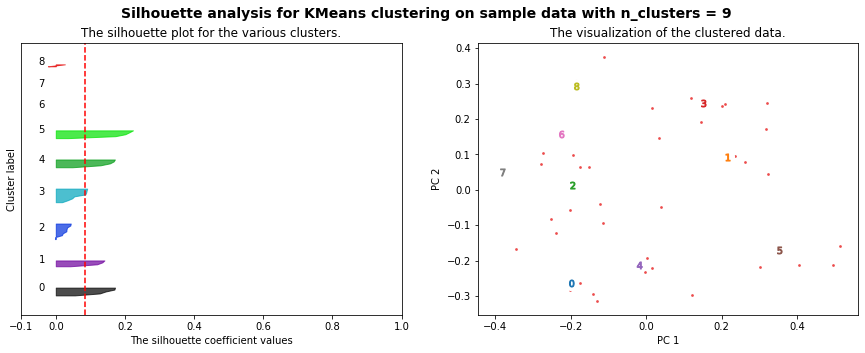

For n_clusters = 9, The average silhouette_score is : 0.084


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


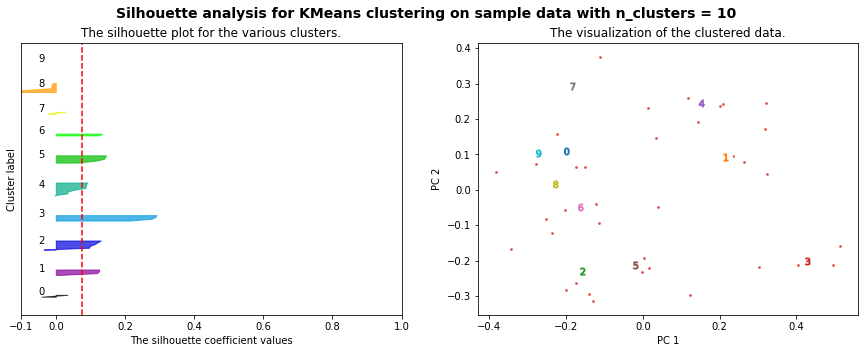

For n_clusters = 10, The average silhouette_score is : 0.076


In [0]:
X = speechTFVects.toarray()
max_sil = 0
n_clus=0
for c in [3,4,5,6,7,8,9,10]:
    sil = plotSilhouette2(c, X, reducedPCA_speechData, speechPCA)
    if sil > max_sil:
        max_sil = sil
        n_clus = c

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [0]:
speechCoocMat = speechTFVects * speechTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
speechCoocMat.setdiag(0)

In [0]:
linkage_matrix = scipy.cluster.hierarchy.ward(speechCoocMat.toarray())


/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


The hierarchical cluster's first grouping gives us two big groups. Very interestingly, the green group coincides in being, almost in all the cases, the year in which the presidents start their mandate (1980, 1985, 1990, 1995, 2000, 2001, 2011, 2016)! 

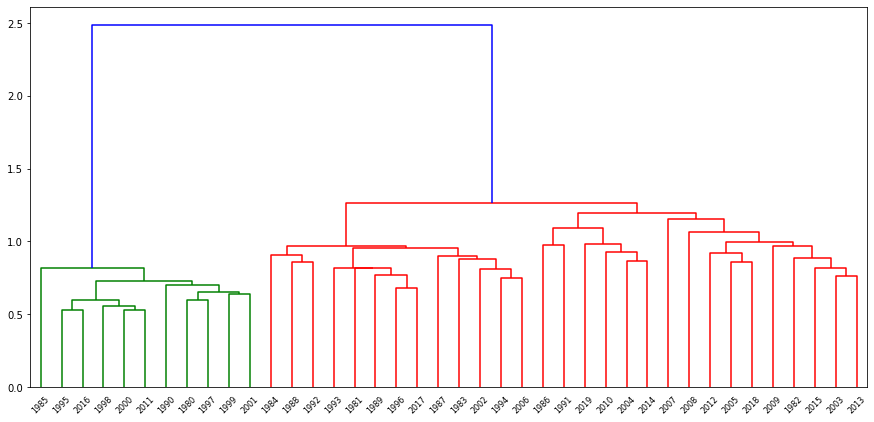

In [0]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True,labels=list(speech['year']))


The results for the other possible groupings are more hectic: They are more difficult to interpret and we don't have a possible explanation yet. 

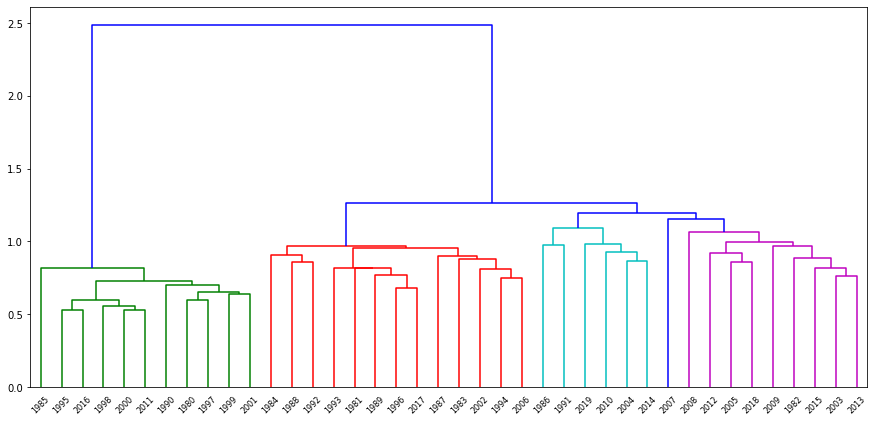

In [0]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.1)

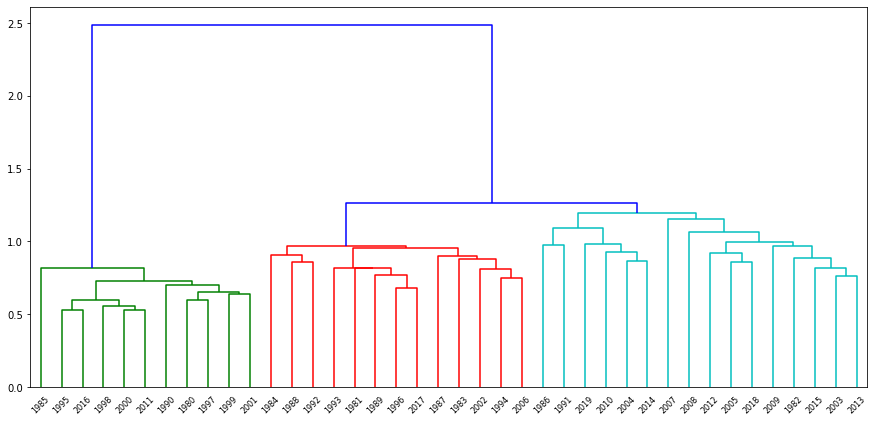

In [0]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.2)

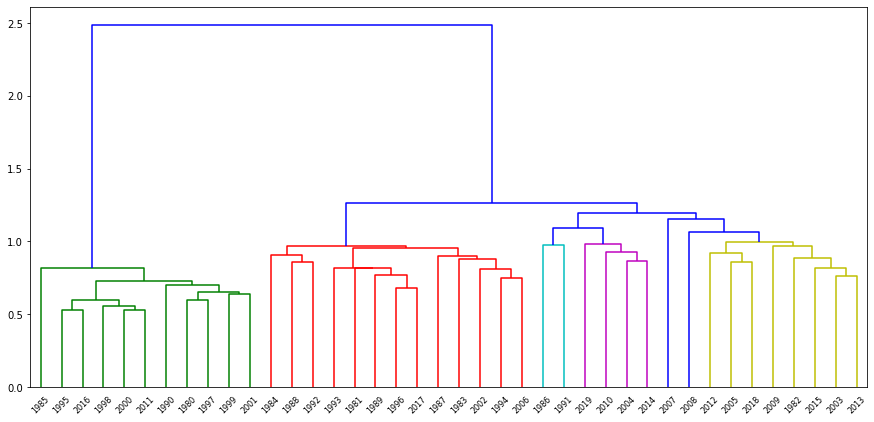

In [0]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.02)

Checking the comparison between hiearchical clustering and k-means, we check that the performance of the latter is better in terms of the following indicators: homogeneity, completeness, v-measure and adjuted rand score. 

In [0]:
speech['wald7'] = scipy.cluster.hierarchy.fcluster(linkage_matrix, 7, 'maxclust')


In [0]:
print("Wald - 7 groups:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech['president'], speech['wald7'])))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech['president'], speech['wald7'])))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech['president'], speech['wald7'])))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech['president'], speech['wald7'])))

Wald - 7 groups:
Homogeneity: 0.249
Completeness: 0.276
V-measure: 0.262
Adjusted Rand Score: 0.046


In [0]:
print("K-means (k=7):")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech['president'], speech['kmeans7'])))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech['president'], speech['kmeans7'])))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech['president'], speech['kmeans7'])))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech['president'], speech['kmeans7'])))

K-means (k=7):
Homogeneity: 0.836
Completeness: 0.823
V-measure: 0.830
Adjusted Rand Score: 0.680


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

Applying topic modeling to the tokenized text:

In [0]:
speech['tokenized_text'] = speech['cleaned text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))


In [0]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [0]:
speech['normalized_tokens'] = speech['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [0]:
speech['reduced_tokens'] = speech['normalized_tokens'].apply(lambda x: dropMissing(x, speechTFVectorizer.vocabulary_.keys()))

In [0]:
dictionary_speech = gensim.corpora.Dictionary(speech['reduced_tokens'])


In [0]:
corpus_speech = [dictionary_speech.doc2bow(text) for text in speech['reduced_tokens']]

In [0]:
gensim.corpora.MmCorpus.serialize('speech_peru.mm', corpus_speech)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
n_topics = 8
speech_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_speech,
                                             id2word=dictionary_speech,
                                             num_topics=n_topics,
                                             alpha='auto',
                                             eta='auto'
                                            )

In [0]:
speech_ldaDF = pandas.DataFrame({
        'year' : speech['year'],
        'president': speech['president'],
        'year-president': speech['year-president'],
        'topics' : [speech_lda[dictionary_speech.doc2bow(l)] for l in speech['reduced_tokens']]
    })

In [0]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(speech_ldaDF) for i in range(speech_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(speech_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(speech_lda.num_topics):
    speech_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [0]:
speechDFV = speech_ldaDF[['topic_%d' %x for x in range(n_topics)]]
speechDFVisN = speech_ldaDF[['year-president']]
speechDFVis = speechDFV.as_matrix(columns=None)
speechDFVisNames = speechDFVisN.as_matrix(columns=None)
topic_labels = ['Topic #{}'.format(k) for k in range(n_topics)]

In [0]:
topicsDict = {}
for topicNum in range(speech_lda.num_topics):
    topicWords = [w for w, p in speech_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7
0,año,año,año,año,año,país,millón,año
1,perú,país,millón,país,perú,año,gobernar,país
2,millón,millón,perú,gobernar,país,perú,país,perú
3,gobernar,nacional,nacional,perú,millón,gobernar,año,gobernar
4,país,gobernar,país,nacional,peruano,millón,perú,millón
5,nacional,perú,gobernar,millón,nacional,nacional,nacional,nacional
6,peruano,social,peruano,social,gobernar,peruano,peruano,peruano
7,político,peruano,político,peruano,político,social,social,desarrollar
8,desarrollar,inversión,inversión,sector,desarrollar,económico,dólar,político
9,sector,político,desarrollar,inversión,social,político,público,público


Here we see the words that define each of the 8 topics. They seem very similar and since they are presidential communication that tell about the development of a contry within a year, it is no wonder that these are the most used words. 

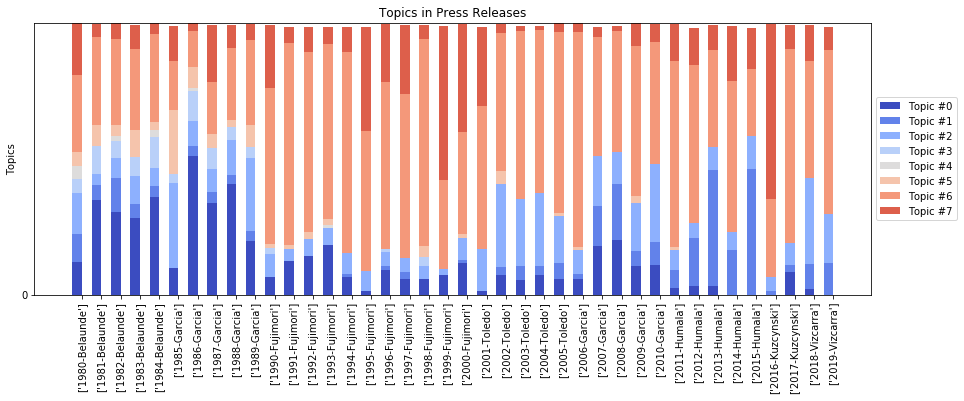

In [0]:
plt.figure(figsize = (15,5))

N = speech_ldaDF.shape[0]
ind = np.arange(N)
K = speech_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, speechDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, speechDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += speechDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, speechDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

Here we see how the topics distribute in speech. It is interesting to see that topic 6 is very common since 1990 and has bee the most important one since then, while topic 0 was much more frequent from 1980 to 1990, and it fades away and practically disappears at the end of the span. 


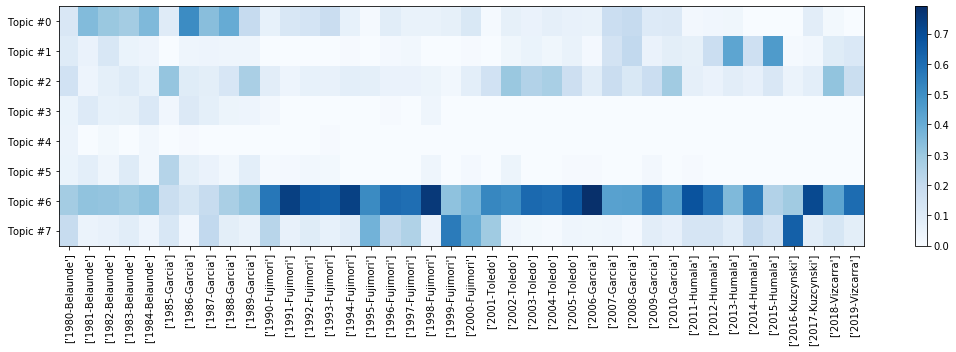

In [0]:
plt.figure(figsize = (15,5))
plt.pcolor(speechDFVis.T, norm=None, cmap='Blues')
plt.xticks(np.arange(speechDFVis.shape[0])+0.5, speechDFVisNames);
plt.yticks(np.arange(speechDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

This heatmap shows a confirmation of what the stacked bars showed: topic 6 is a very hot one and it is very common across all spans.  The word frequency between the topics 0 and 6 are very similar in their first 30 words:


<Figure size 432x288 with 0 Axes>

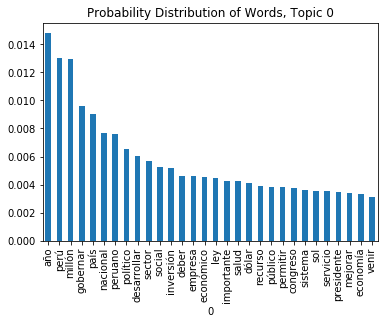

In [0]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(0, topn=30))
plt.figure()
topic1_df.plot.bar(legend = False, x = 0)
plt.title('Probability Distribution of Words, Topic 0')
plt.show()

<Figure size 432x288 with 0 Axes>

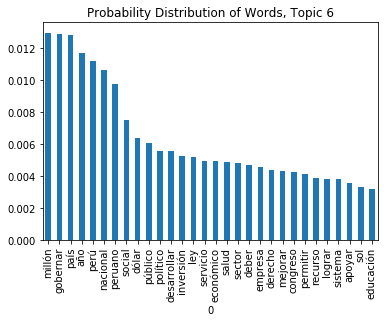

In [0]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(6, topn=30))
plt.figure()
topic1_df.plot.bar(legend = False, x = 0)
plt.title('Probability Distribution of Words, Topic 6')
plt.show()



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?) </span>


In the following analysis we will make dinamic topic modeling. We will split the speeches by presidential periods, and set the topics to 7. 

In [0]:
time_slice_speech = [5, 5, 5, 6, 5, 5, 5, 4]
n_topics = 7

In [0]:
from gensim.models import ldaseqmodel


In [0]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus_speech,
                                 id2word=dictionary_speech,
                                 time_slice=time_slice_speech,
                                 num_topics=n_topics)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [0]:
ldaseqDF = pandas.DataFrame({
        'name' : speech['year-president'],
        'topics' : [ldaseq[dictionary_speech.doc2bow(l)] for l in speech['reduced_tokens']]
    })

In [0]:
ldaseqDF['topics'][0]

array([0.05931651, 0.02192396, 0.0106327 , 0.04464594, 0.02034721,
       0.0841845 , 0.75894917])

In [0]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaseqDF) for i in range(ldaseq.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaseqDF['topics']):
    for topicNum, prob in enumerate(topicTuples):
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(ldaseq.num_topics):
    ldaseqDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [0]:
ldaseqDFV = ldaseqDF[['topic_%d' %x for x in range(n_topics)]]
ldaseqDFVisN = ldaseqDF[['name']]
ldaseqDFVis = ldaseqDF.as_matrix(columns=['topic_0',
                                          'topic_1',
                                          'topic_2',
                                          'topic_3',
                                          'topic_4',
                                          'topic_5',
                                          'topic_6'])
#ldaseqDFVisNames = ldaseqDFVis.as_matrix(columns=None)
ldaseqDFVisNames = speech['year-president']

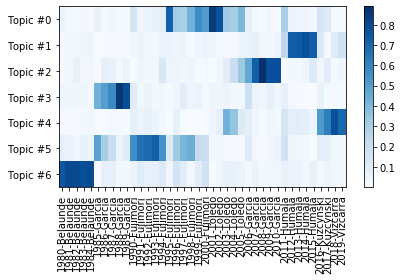

In [0]:
plt.pcolor(ldaseqDFVis.T, norm=None, cmap='Blues')
plt.xticks(np.arange(ldaseqDFVis.shape[0])+0.5, ldaseqDFVisNames);
plt.yticks(np.arange(ldaseqDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

Very interestingly, the topics align very well to the presidential terms, in a way in which every president is it's own topic.  